In [82]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error as mape, root_mean_squared_error as rmse
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import itertools
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
from tqdm import tqdm


import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('../data/processed/language_based_count.csv', parse_dates=['Date'])

In [3]:
df.head()

,Date,de,en,es,fr,ja,ru,zh
0,2015-07-01,783.948744,3941.539643,1150.304489,510.261085,624.805016,677.470828,287.340659
1,2015-07-02,773.271239,3928.803136,1099.275870,513.537854,717.489384,689.192498,287.767140
2,2015-07-03,742.182383,3730.086404,1010.977482,493.793388,647.996628,638.780586,285.858163
3,2015-07-04,681.071771,3883.418295,949.222398,527.819811,814.146568,600.830911,288.622808
4,2015-07-05,791.742536,4010.695701,1032.293945,518.211860,781.063063,639.865488,307.882010


In [19]:
df.set_index(df['Date'], inplace=True)
df.drop(columns=['Date'], inplace=True)

In [20]:
# Trend only for the english language articles
en_view = df['en']
fig = px.line(en_view, y='en')
fig.update_layout(title='View trend for English articles', yaxis_title='View Count', xaxis_title='Date')

In [21]:

# Decomposing the series
decomposed_series = seasonal_decompose(en_view) 

In [23]:
trend = decomposed_series.trend
seasonal = decomposed_series.seasonal
residual = decomposed_series.resid


In [56]:
fig = make_subplots(rows=4, cols=1)

fig.add_trace(go.Line(x=en_view.index, y=en_view.values, name='Original'), row=1, col=1)
fig.add_trace(go.Line(x=trend.index, y=trend.values, name='Trend'), row=2, col=1)
fig.add_trace(go.Line(x=seasonal.index, y=seasonal.values, name='Seasonal'), row=3, col=1)
fig.add_trace(go.Line(x=residual.index, y=residual.values, name='Residual'), row=4, col=1)

fig.update_xaxes(row=1, col=1, visible=False)
fig.update_xaxes(row=2, col=1, visible=False)
fig.update_xaxes(row=3, col=1, visible=False)

fig.update_xaxes(
    row=4, col=1,
    showticklabels=True,
    ticks="outside",
    title_text="Date"
)

fig.update_layout(title = 'Seasonal Decomposition', xaxis_title = 'Date')
fig.show()

In [ ]:
# Dickey Fuller Test for checking stationarity
def df_test(x):
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])

df_test(en_view)

ADF Stastistic: -2.425848
p-value: 0.134573


#### 🦉 ✒️ Pretty high p value hence not stationary so ARIMA , SARIMA cannot be applied

In [75]:
# Make the time series stationary
en_view_diff = en_view - en_view.shift(1)
en_view_diff.dropna(inplace=True)
df_test(en_view_diff)
fig = px.line(x=en_view_diff.index,y=en_view_diff.values)
fig.update_yaxes(visible=False)
fig.update_layout(xaxis_title='Date')

ADF Stastistic: -8.259663
p-value: 0.000000


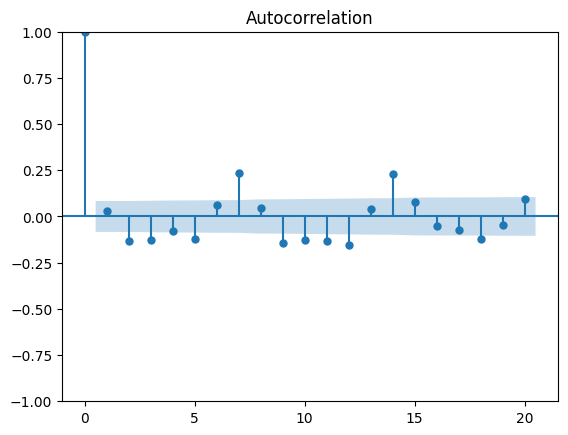

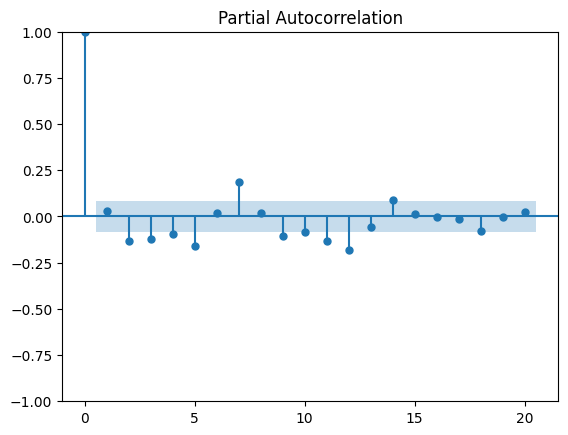

In [ ]:
# Plotting acf and pcf for p,q,d values

acf=plot_acf(en_view_diff,lags=20, )
pacf=plot_pacf(en_view_diff,lags=20)


# Arima Model

In [71]:
train_df = en_view[:-40]
test_df = en_view[-40:]

In [88]:
# Base model 
p = range(0, 4)
d = range(0, 3)
q = range(0, 4)

pdq = list(itertools.product(p, d, q))
best_mape = np.inf
best_rmse = np.inf
best_order = None
best_model = None

for order in tqdm(pdq, desc="Searching ARIMA orders"):
    try:
        model = ARIMA(train_df, order=order)
        fitted = model.fit()
        forecasted = fitted.forecast(40)
        mape_ = np.mean(np.abs(forecasted - test_df.values)/np.abs(test_df.values))
        rmse_ = np.mean((forecasted - test_df.values)**2)**.5
        if mape_ < best_mape:
            best_mape = mape_
            best_rmse = rmse_
            best_order = order
    except Exception as e:
        print(f'Model not trained {e}')
        continue
print(f'Best Order: {best_order}\nBest MAPE: {best_mape}\nBest RMSE: {best_rmse}')


Searching ARIMA orders: 100%|██████████| 48/48 [00:03<00:00, 12.33it/s]

Best Order: (2, 1, 3)
Best MAPE: 0.05768220533631836
Best RMSE: 430.8237846196695


In [85]:
model = ARIMA(train_df, order=order)
fitted = model.fit()
x = fitted.forecast(40)

In [86]:
x

2016-11-22    4830.088214
2016-11-23    4830.088214
2016-11-24    4830.088214
2016-11-25    4830.088214
2016-11-26    4830.088214
2016-11-27    4830.088214
2016-11-28    4830.088214
2016-11-29    4830.088214
2016-11-30    4830.088214
2016-12-01    4830.088214
2016-12-02    4830.088214
2016-12-03    4830.088214
2016-12-04    4830.088214
2016-12-05    4830.088214
2016-12-06    4830.088214
2016-12-07    4830.088214
2016-12-08    4830.088214
2016-12-09    4830.088214
2016-12-10    4830.088214
2016-12-11    4830.088214
2016-12-12    4830.088214
2016-12-13    4830.088214
2016-12-14    4830.088214
2016-12-15    4830.088214
2016-12-16    4830.088214
2016-12-17    4830.088214
2016-12-18    4830.088214
2016-12-19    4830.088214
2016-12-20    4830.088214
2016-12-21    4830.088214
2016-12-22    4830.088214
2016-12-23    4830.088214
2016-12-24    4830.088214
2016-12-25    4830.088214
2016-12-26    4830.088214
2016-12-27    4830.088214
2016-12-28    4830.088214
2016-12-29    4830.088214
2016-12-30  

In [90]:
import matplotlib.pyplot as plt
fitted.plot_predict(dynamic=False)
plt.show()

AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'